# Tutorial: Interactive Maps with Python, Part 2
## Custom Plots on Geographic Maps

This is part 2 of our 3-part tutorial on interactive maps with python. We are using the NYC bikeshare data as an example. In part 1 we covered how to do basic visualizations with python and folium. Here we will dig a little deeper into how to make custom map overlays.

In part 1, we already noticed some bike migration: at 9am, some regions have more bike departures and different regions have more bike arrivals. In this tutorial we will see if we can show which *paths* people take. We will put particular emphasis on creating a customized visual appearance. Specifically, we will 
1. customize the effect of overlapping paths to show traffic density, and 
2. we will add a glow effect to draw attention to high density areas. 
This design is loosly inspired by a map created by facebook [https://newsroom.fb.com/news/2017/06/two-billion-people-coming-together-on-facebook/].

To achieve these effects we will use a raster layer (i.e. and image overlay) and draw our own pixels instead of using the built-in objects in folium to draw the paths (e.g. using PolyLine).



In [1]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters

As before, we load data from the NYC bike share program

In [3]:
bike_data = pd.read_csv("/home/tallys/git/master-research/src/datasets/citibike/JC-201610-citibike-tripdata.csv")
bike_data["Start Time"] = pd.to_datetime(bike_data["Start Time"])
bike_data["Stop Time"] = pd.to_datetime(bike_data["Stop Time"])
bike_data["hour"] = bike_data["Start Time"].map(lambda x: x.hour)
bike_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,hour
0,183,2016-10-01 00:00:38,2016-10-01 00:03:41,3272,Jersey & 3rd,40.723332,-74.045953,3203,Hamilton Park,40.727596,-74.044247,24510,Subscriber,1968.0,1,0
1,379,2016-10-01 00:04:57,2016-10-01 00:11:17,3273,Manila & 1st,40.721651,-74.042884,3272,Jersey & 3rd,40.723332,-74.045953,26152,Subscriber,1987.0,1,0
2,414,2016-10-01 00:05:18,2016-10-01 00:12:13,3183,Exchange Place,40.716247,-74.033459,3211,Newark Ave,40.721525,-74.046305,26213,Subscriber,NaN,0,0
3,2411,2016-10-01 00:15:23,2016-10-01 00:55:35,3199,Newport Pkwy,40.728745,-74.032108,3199,Newport Pkwy,40.728745,-74.032108,26278,Subscriber,1975.0,1,0
4,170,2016-10-01 00:21:25,2016-10-01 00:24:16,3272,Jersey & 3rd,40.723332,-74.045953,3278,Monmouth and 6th,40.725685,-74.048790,26152,Subscriber,1990.0,1,0


## Creating the intensity map
### adding lines
We will start by creating a grayscale image where intensity in each pixel is proportional to the number of trips passing through that pixel. We'll use a numpy array to store the pixel values. First we'll write a function that *adds* a line to an image. We'll start with a new numpy array full of zeros, this will be come our final image.  We will then draw a line using pillow on a second canvas and **add** the resulting pixel values to the existing canvas.

### Creating Glow Effect
Adding a glow effect to your maps can draw the attention of your audience and instantly focus their attention to certain parts of the map. We will create a glow effect in areas where many lines intersect (high density of traffic). We'll use a convolution filter [https://en.wikipedia.org/wiki/Convolution].


In [4]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel =  
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

### Adding color
To convert the map data to colors that are pleasing to the eye, we will apply a saturation function and then apply a color map. This (roughly) mimics the effect of saturation in a photograph or on your retina.

In [5]:
def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

#### A quick test of the drawing function
just to demonstrate the effect and check that everything is working

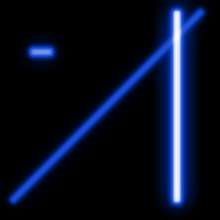

In [64]:
xys = [(30,50,50,50), (175,10,175,200), (200,10,10,200)]  # some lines
weights = np.array([ 2,5,.7])/100  # some weights

# create the image_data
new_image_data = add_lines(np.zeros((220,220)),
                           xys,
                           width=6,
                           weights=weights) 

# show the image
Image.fromarray(to_image(new_image_data),mode="RGBA")

### Making a stationary plot of the data
We will visualize every trip by plotting a line as above. Multiple trips will add to show traffic density.

### Convert Latitude and Longitude to Pixel Coordinates
Since folium (and leaflet.js) uses Mercator projection we can convert easily from latitude/longitude coordinates to pixel coordinates using a multiplier (i.e., y_pixel = A*latitude, x_pixel= B* longitude). We will choose A and B so that all our paths fit in the image and have the right aspect ratio.

In [8]:
min_lat = bike_data["Start Station Latitude"].min()
max_lat = bike_data["Start Station Latitude"].max()
max_lon = bike_data["Start Station Longitude"].max()
min_lon = bike_data["Start Station Longitude"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["Start Station Latitude"], 
                                       row["Start Station Longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["End Station Latitude"], 
                                   row["End Station Longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

### Draw all the trips for one time of day

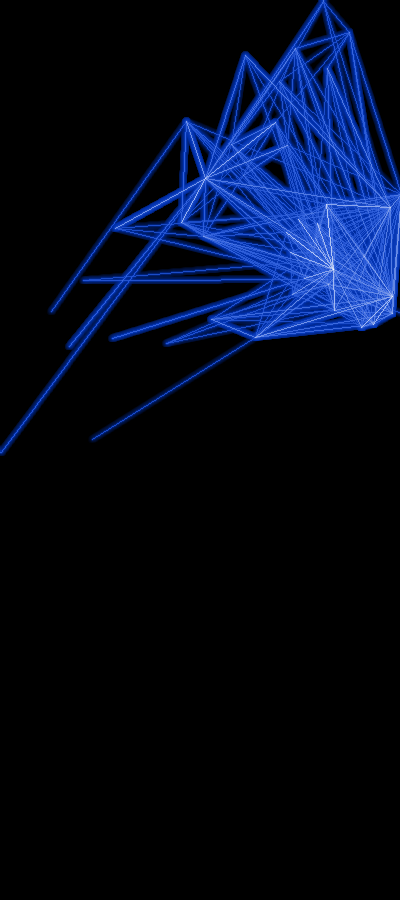

In [72]:
paths = bike_data[bike_data.hour==8]
paths = paths.iloc[:3000,:]

# generate empty pixel array, choose your resolution
image_data = np.zeros((900,400))

# generate pixel coordinates of starting points and end points
xys = [row_to_pixel(row, image_data.shape) for i, row in paths.iterrows()]

# draw the lines
image_data = add_lines(image_data, xys, weights=None, width = 1)
Image.fromarray(to_image(image_data*10)[:,:,:3],mode="RGB")

### Unique Paths
First we will group individual trips by unique origin and destination. For the first visualization we have in mind this does not make a difference and it will make some of the drawing go much faster. For that we need to do 3 things:
- make a dataframe with locations for each station
- make a second dataframe with each row representing a unique path
- join these two dataframes

In [10]:
# make a list of locations (latitude longitude) for each station id
locations = bike_data.groupby("Start Station ID").mean()
locations = locations.loc[:,["Start Station Latitude", "Start Station Longitude"]]

# group by each unique pair of (start-station, end-station) and count the number of trips
bike_data["path_id"] = [(id1,id2) for id1,id2 in zip(bike_data["Start Station ID"], 
                                                     bike_data["End Station ID"])]
paths = bike_data[bike_data["hour"]==9].groupby("path_id").count().iloc[:,[1]] 
paths.columns = ["Trip Count"]

# select only paths with more than X trips
paths = paths[paths["Trip Count"]>5]
paths["Start Station ID"] = paths.index.map(lambda x:x[0])
paths["End Station ID"] = paths.index.map(lambda x:x[1])
paths = paths[paths["Start Station ID"]!=paths["End Station ID"]]

# join latitude/longitude into new table
paths = paths.join(locations,on="Start Station ID")
locations.columns = ["End Station Latitude","End Station Longitude"]
paths = paths.join(locations,on="End Station ID")
paths.index = range(len(paths))

paths.shape

(75, 7)

In [11]:
def get_image_data(paths, min_count=0, max_count=None):
    # generate empty pixel array
    image_data = np.zeros((900*2,400*2))
    
    # generate pixel coordinates of starting points and end points
    if max_count is None:
        max_count = paths["Trip Count"].max()+1
    selector = (paths["Trip Count"]>= min_count) & (paths["Trip Count"]< max_count)
    xys = [row_to_pixel(row, image_data.shape) for i, row in paths[selector].iterrows()]

    # draw the lines
    image_data = add_lines(image_data, xys, weights=paths["Trip Count"], width = 1)
    return image_data

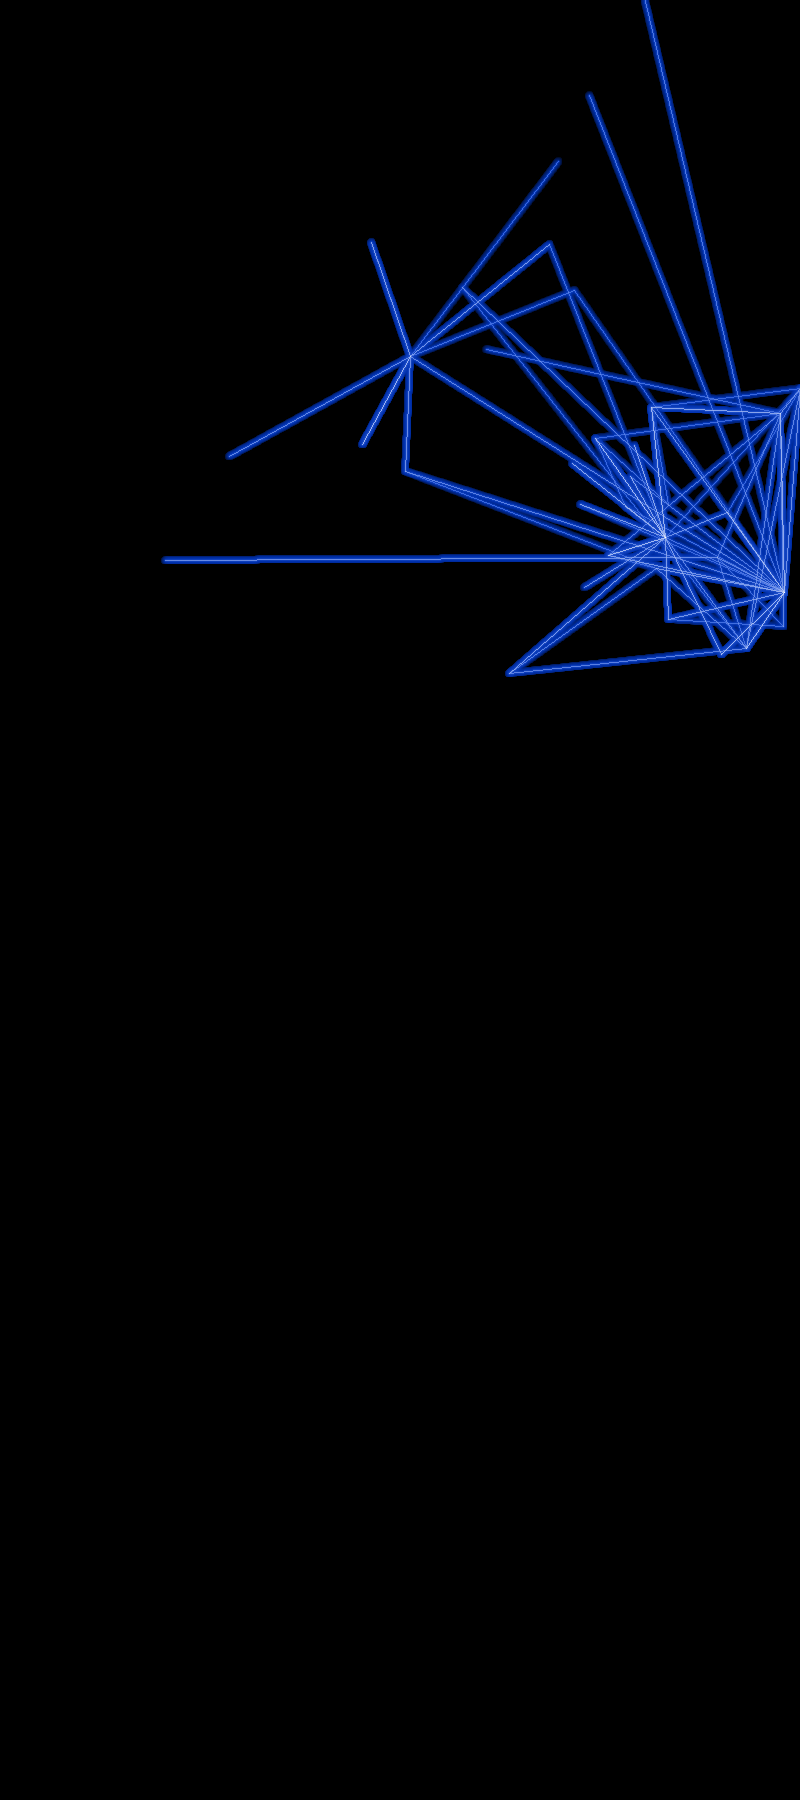

In [12]:
Image.fromarray(to_image(get_image_data(paths)*10)[:,:,:3],mode="RGB")

### Adding an alpha channel
To blend the image we just created with the map, we need to add an alpha channel which controls the transparency of our image. One trick to retain the effect of blur/glow we created is that we will convert RGB color coordinates to HSV (Hue, Saturation, Value) color coordinates and use the original color *value* (v) as an alpha channel and set the color value (v) to 1.

In [13]:
def add_alpha(image_data):
    """
    Uses the Value in HSV as an alpha channel. 
    This creates an image that blends nicely with a black background.
    """
    
    # get hsv image
    hsv = rgb_to_hsv(image_data[:,:,:3].astype(float)/255)
    
    # create new image and set alpha channel
    new_image_data = np.zeros(image_data.shape)
    new_image_data[:,:,3] = hsv[:,:,2]
    
    # set value of hsv image to either 0 or 1.
    hsv[:,:,2] = np.where(hsv[:,:,2]>0, 1, 0)
    
    # combine alpha and new rgb
    new_image_data[:,:,:3] = hsv_to_rgb(hsv)
    return new_image_data

and finally, we draw the map with the image overlay.

In [66]:
# create the map
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter",
                        width='50%')

# create the overlay
map_overlay = add_alpha(to_image(image_data*10))

# compute extent of image in lat/lon
aspect_ratio = map_overlay.shape[1]/map_overlay.shape[0]
delta_lat = (max_lon-min_lon)/aspect_ratio*np.cos(min_lat/360*2*np.pi)
# plugins.FloatImage

# add the image to the map
img = folium.raster_layers.ImageOverlay(map_overlay,
                           bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                           opacity = 1,
                           name = "Paths")

img.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# show the map
folium_map

In [19]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter",
                        width='50%')

thresholds = [5,15,25]

for i,t in enumerate(thresholds):
    upper = thresholds[i+1] if i<len(thresholds)-1 else None
    image_data = get_image_data(paths, t, upper)
    name = "{} < Num. Trips < {}".format(t,"max" if upper is None else upper)

    map_overlay = add_alpha(to_image(image_data*10))
    delta_lat = (max_lon-min_lon)/map_overlay.shape[1]*map_overlay.shape[0]*np.cos(min_lat/360*2*np.pi)
    img = folium.raster_layers.ImageOverlay(map_overlay,
                               bounds = [(max_lat-delta_lat,min_lon),(max_lat,max_lon)],
                               name = name)

    img.add_to(folium_map)

lc = folium.LayerControl().add_to(folium_map)

folium_map